In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ortho_group 
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(0)

def polynomial_features(X):
    
    """
    
    X: shape (n_samples, n_features = 2)
    Returns: shape (n_samples, n_features = 6): [1, x1, x2, x1^2, x1*x2, x2^2]
    
    """
    
    x1 = X[:,0]
    x2 = X[:,1]
    interaction = x1*x2
    
    return np.stack([
        np.ones(len(X)),     # bias
        x1, x2,              # linear
        x1**2, x2**2,        # quadratic
        interaction     
    ])
    
def sigmoid(x):
    return 1/(1+np.exp(-x))


WEIGHTS = np.array([0.1, 0.2, -0.3, 0.4, -0.5, 0.6]) 
    

In [2]:
def generate_synthetic_dataset(
    pi = 0.5,
    cov_scale = 3.5,
    mean_shift_scale = 1.5,
    n_samples = 1000,
    random_seed = 0
):
    """
    Generates:
      - 'original' data from N(mean0, cov0),
      - 'shifted' data from N(mean1, cov1) with mixing pi,
      - returns (X, y) arrays.

    mean0 = [10, 20]
    cov0 is 2x2 PSD from random matrix * 10
    mean1 = mean0 * mean_shift_scale
    cov1 = random rotation of cov0 * cov_scale
    """
    
    np.random.seed(random_seed)
    
    # Original distro
    A = np.random.rand(2,2)*10
    cov0 = np.dot(A, A.T)
    mean0 = [10,20]
    
    # Shifted distro
    random_ortho = ortho_group.rvs(dim=2)
    cov1 = random_ortho @ cov0 @ random_ortho.T 
    cov1 *= cov_scale
    mean1 = [m * mean_shift_scale for m in mean0]
    
    
    choices = np.random.choice([0,1], size=n_samples, p=[pi, 1-pi])
    X = np.zeros((n_samples, 2))
    
    for i in range(n_samples):
        if choices[i] == 0:
            X[i] = np.random.multivariate_normal(mean0, cov0)
        else:
            X[i] = np.random.multivariate_normal(mean1, cov1)
            
            
            
    X_poly = polynomial_features(X)
    z = np.dot(WEIGHTS,X_poly)
    probs = sigmoid(z)
    y = np.random.binomial(1, probs)
    
    return X, y

In [3]:
import numpy as np  
p = 1
choices = np.random.choice([0,1], size=10, p=[p, 1-p])
choices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [4]:

# def create_shifted_datasets(output_folder="generated_data"):
#     """
#     Creates multiple CSVs in output_folder for different pi values.
#     """
#     os.makedirs(output_folder, exist_ok=True)
    
#     # "original" data: fix pi=0 => everything from dist 0
#     X_orig, y_orig = generate_synthetic_dataset(pi=1.0, cov_scale=1, mean_shift_scale=1, n_samples=1000)
#     df_orig = pd.DataFrame(X_orig, columns=['feature_1', 'feature_2'])
#     df_orig['target'] = y_orig
#     df_orig.to_csv(os.path.join(output_folder, 'original.csv'), index=False)
    
#     # create multiple shifts
#     pi_values = [0.1, 0.5, 0.7, 0.9]
#     for pi in pi_values:
#         X_shift, y_shift = generate_synthetic_dataset(pi=pi, cov_scale=3.5, mean_shift_scale=1.5, n_samples=1000)
#         df_shift = pd.DataFrame(X_shift, columns=['feature_1', 'feature_2'])
#         df_shift['target'] = y_shift
#         df_shift.to_csv(os.path.join(output_folder, f'shifted_pi_{pi}.csv'), index=False)




In [5]:
def visualize_feature_shifts(folder="data_folder"):
    """
    Plots scatter/hist distributions for 'original.csv' vs. each 'shifted_pi_*.csv' file
    to illustrate how the distributions differ.
    """
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]
    original_file = [f for f in files if "original.csv" in f]
    
    if len(original_file) == 0:
        print("No original.csv found!")
        return
    
    # Load original
    df_orig = pd.read_csv(os.path.join(folder, original_file[0]))
    
    # For each shifted
    shifted_files = [f for f in files if "shifted_" in f]
    
    # 2D Scatter
    plt.figure(figsize=(8,6))
    plt.scatter(df_orig['feature_1'], df_orig['feature_2'], alpha=0.3, label='Original')
    
    for sf in shifted_files:
        df_s = pd.read_csv(os.path.join(folder, sf))
        plt.scatter(df_s['feature_1'], df_s['feature_2'], alpha=0.3, label=sf)
    
    plt.legend()
    plt.title("Scatterplot: Original vs Shifted Distributions")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Histograms
    for sf in shifted_files:
        df_s = pd.read_csv(os.path.join(folder, sf))
        
        fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
        sns.histplot(df_orig['feature_1'], color="blue", alpha=0.4, ax=axes[0], label='Original f1')
        sns.histplot(df_s['feature_1'], color="red", alpha=0.4, ax=axes[0], label=f'{sf} f1')
        axes[0].set_title("Feature 1 distribution")
        axes[0].legend()
        
        sns.histplot(df_orig['feature_2'], color="blue", alpha=0.4, ax=axes[1], label='Original f2')
        sns.histplot(df_s['feature_2'], color="red", alpha=0.4, ax=axes[1], label=f'{sf} f2')
        axes[1].set_title("Feature 2 distribution")
        axes[1].legend()
        
        plt.suptitle(f"Feature Distributions Comparison: {sf}")
        plt.show()




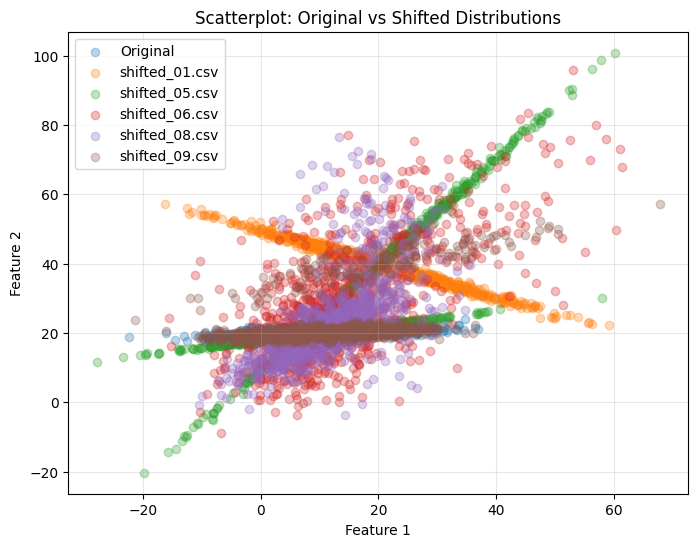

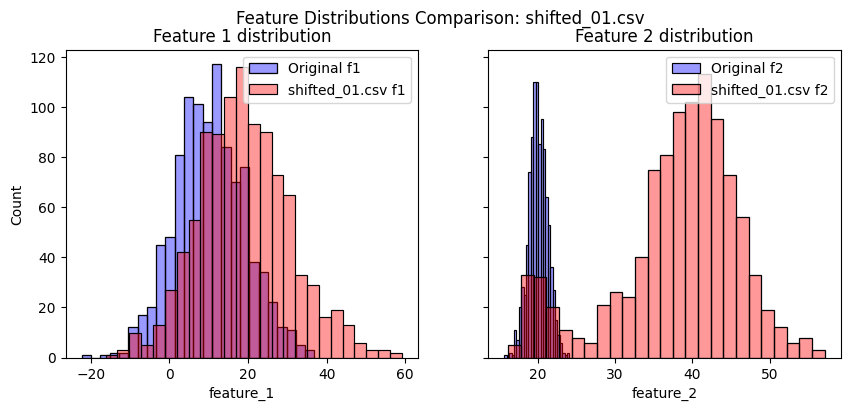

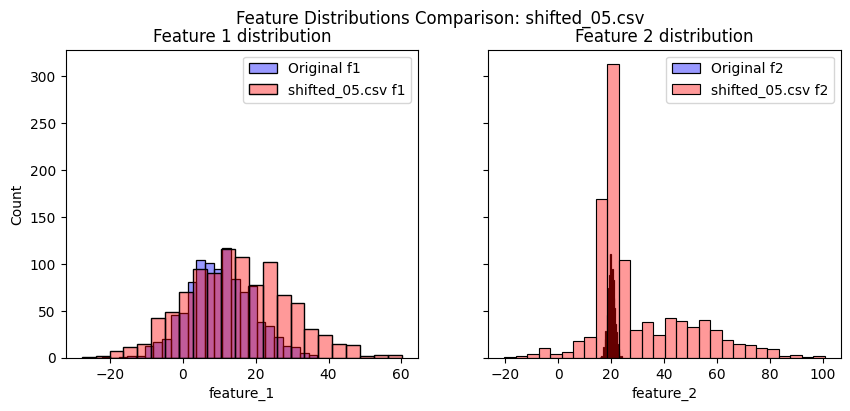

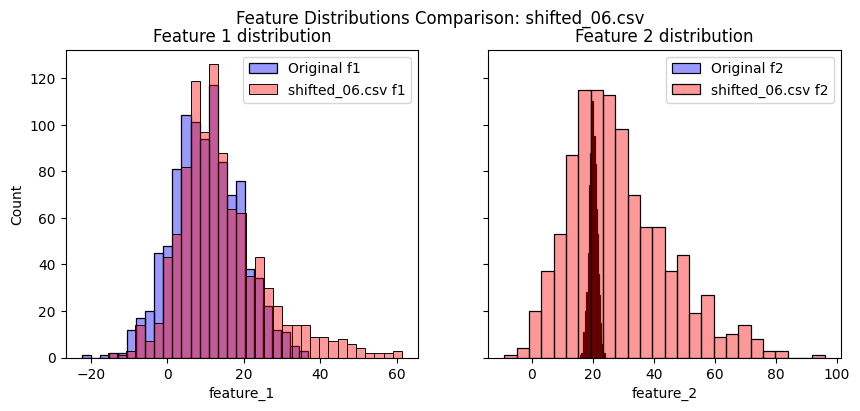

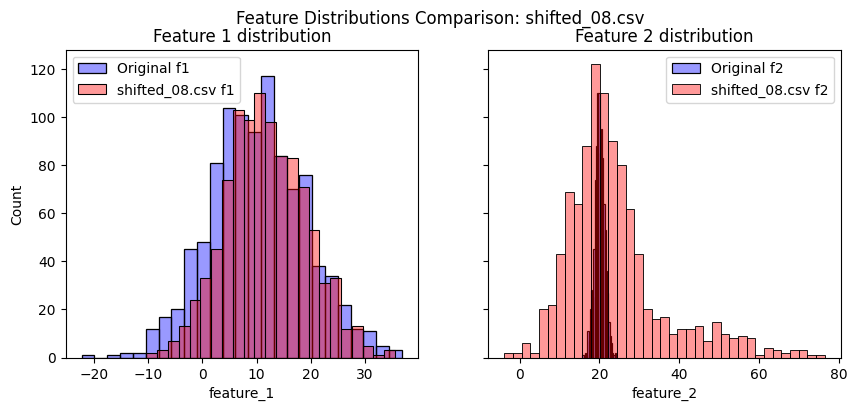

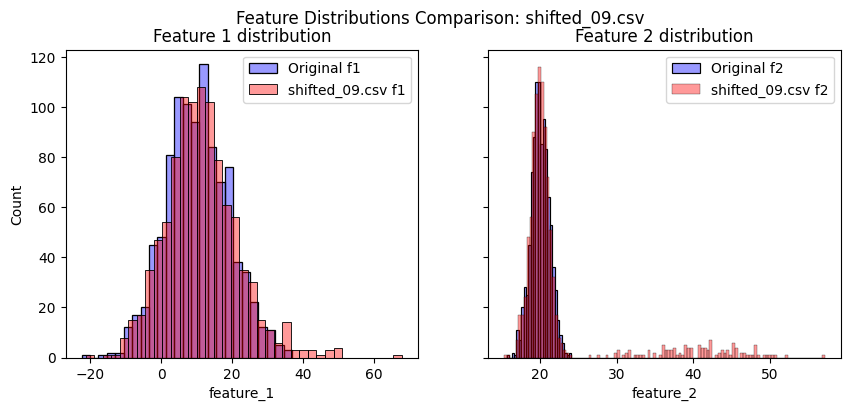

In [6]:

visualize_feature_shifts("data_folder")

In [11]:
def evaluate_models_on_shifts(folder="data_folder"):
    """
    1) Train a DecisionTree and a GradientBoosting on original.csv
    2) Evaluate them on multiple shifted files
    3) Print accuracy, F1, AUC
    4) Plot ROC curves
    """
    from sklearn.metrics import roc_curve
    
    # 1) Load original => train
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    
    # Fit Decision Tree
    dtc = DecisionTreeClassifier(max_depth=4, min_samples_leaf=13)
    dtc.fit(X_train, y_train)
    
    # Fit Gradient Boosting
    gbc = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc.fit(X_train, y_train)
    
    # 2) Evaluate on each shifted
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    
    plt.figure(figsize=(10,5))
    for model, name, color in zip(
        [dtc, gbc],
        ["DecisionTree", "GradientBoosting"],
        ["blue", "red"]
    ):
        for test_file in test_files:
            df_test = pd.read_csv(os.path.join(folder, test_file))
            X_test = df_test.drop('target', axis=1)
            y_test = df_test['target']
            
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)
            
            print(f"=== {name} on {test_file} ===")
            print(f"Accuracy: {acc:.3f}, F1: {f1:.3f}, AUC: {auc:.3f}")
            print(classification_report(y_test, y_pred))
            print("---------------------------------------------------")
            
            # Plot ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            label_str = f"{name}-{test_file} (AUC={auc:.3f})"
            plt.plot(fpr, tpr, label=label_str, color=color, alpha=0.3)
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves on Shifted Test Sets")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




=== DecisionTree on shifted_01.csv ===
Accuracy: 0.679, F1: 0.704, AUC: 0.746
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       618
           1       0.54      1.00      0.70       382

    accuracy                           0.68      1000
   macro avg       0.77      0.74      0.68      1000
weighted avg       0.83      0.68      0.67      1000

---------------------------------------------------
=== DecisionTree on shifted_05.csv ===
Accuracy: 0.638, F1: 0.536, AUC: 0.728
              precision    recall  f1-score   support

           0       0.95      0.56      0.70       769
           1       0.38      0.90      0.54       231

    accuracy                           0.64      1000
   macro avg       0.67      0.73      0.62      1000
weighted avg       0.82      0.64      0.66      1000

---------------------------------------------------
=== DecisionTree on shifted_06.csv ===
Accuracy: 0.715, F1: 0.659, AUC: 0.735
        

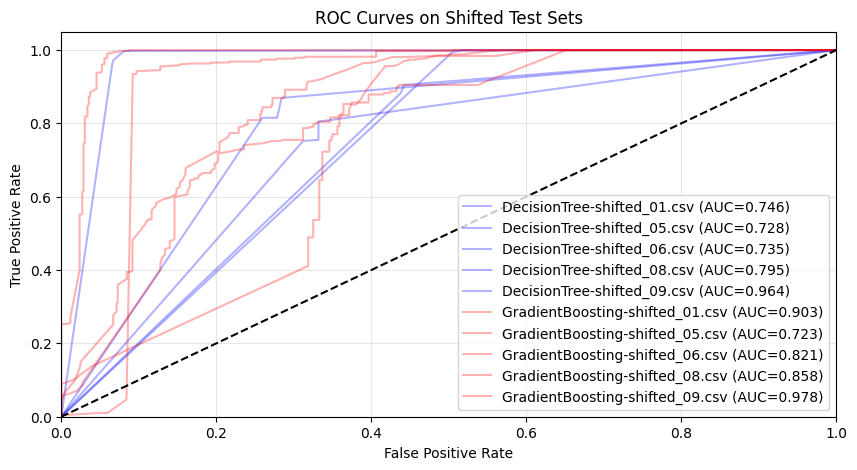

In [12]:
evaluate_models_on_shifts("data_folder")


In [16]:
def generate_adversarial_samples_gbc(model, X, y, epsilon=0.2):
    """
    A naive finite-difference approach:
      - For each sample, we measure how small +/- changes in each feature
        affect the predicted probability of the *true label*
      - Then we pick a direction for each feature that lowers that probability, 
        i.e. an adversarial direction
      - We step by 'epsilon' in that direction
    Returns X_adv (same shape as X)
    """
    X_adv = X.copy()
    X_values = X.values
    
    # We'll do this one sample at a time
    for i in range(len(X)):
        x_i = X_values[i].copy()  # shape (2,) for 2D data
        true_label = y.iloc[i]
        
        # Probability that model predicts y_i
        prob_original = model.predict_proba([x_i])[0][true_label]
        
        # For each feature, do finite difference
        for feat_idx in range(len(x_i)):
            # +delta
            x_i_pos = x_i.copy()
            x_i_pos[feat_idx] += 1e-3
            prob_pos = model.predict_proba([x_i_pos])[0][true_label]
            
            # -delta
            x_i_neg = x_i.copy()
            x_i_neg[feat_idx] -= 1e-3
            prob_neg = model.predict_proba([x_i_neg])[0][true_label]
            
            # We pick the direction that decreases prob_original the most
            # "Gradient" approximation
            grad_est = (prob_pos - prob_neg) / (2e-3)
            # If grad_est > 0 => increasing feature_i increases probability => 
            # to reduce prob_original, we want to move in the negative direction
            direction = -1 if grad_est > 0 else 1
            
            x_i[feat_idx] += direction * epsilon
        
        # Use loc to properly update DataFrame row
        X_adv.iloc[i] = x_i
    
    return X_adv


def adversarial_training_gbc(
    X_train, y_train,
    epsilon=0.2,
    base_model=None,
    retrain=True
):
    """
    1) Fit model on (X_train, y_train)
    2) Generate adversarial samples
    3) Augment training set => (X_train_aug, y_train_aug)
    4) Optionally retrain model on augmented set
    Returns (model, X_train_aug, y_train_aug)
    """
    if base_model is None:
        base_model = GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=4,
            max_features='log2',
            min_samples_leaf=13,
            n_estimators=100,
            subsample=0.7
        )
    
    # 1) initial training
    base_model.fit(X_train, y_train)
    
    # 2) generate adversarial samples
    X_adv = generate_adversarial_samples_gbc(base_model, X_train, y_train, epsilon=epsilon)
    # same labels
    y_adv = y_train.copy()
    
    # 3) augment
    X_train_aug = pd.concat([X_train, X_adv], ignore_index=True)
    y_train_aug = pd.concat([y_train, y_adv], ignore_index=True)
    
    if retrain:
        # Retrain from scratch on augmented data
        adv_model = GradientBoostingClassifier(
            learning_rate=0.05,
            max_depth=4,
            max_features='log2',
            min_samples_leaf=13,
            n_estimators=100,
            subsample=0.7
        )
        adv_model.fit(X_train_aug, y_train_aug)
        return adv_model, X_train_aug, y_train_aug
    else:
        # Just return the base_model that was trained once
        return base_model, X_train_aug, y_train_aug

###############################################################################
# Example usage: compare normal GBC vs adversarial-trained GBC on shifted sets
###############################################################################
def compare_adversarial_training(folder="data_folder"):
    # 1) Load original => train data
    df_orig = pd.read_csv(os.path.join(folder, "original.csv"))
    X_train = df_orig.drop('target', axis=1)
    y_train = df_orig['target']
    
    # Normal GBC
    gbc_normal = GradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=4,
        max_features='log2',
        min_samples_leaf=13,
        n_estimators=100,
        subsample=0.7
    )
    gbc_normal.fit(X_train, y_train)
    
    # Adversarial training
    gbc_adversarial, X_aug, y_aug = adversarial_training_gbc(X_train, y_train, epsilon=0.2, retrain=True)
    
    # 2) Evaluate both on shifted sets
    test_files = [f for f in os.listdir(folder) if f.startswith("shifted_")]
    
    print("\n=== Evaluate Normal GBC vs Adversarial GBC on Shifted Data ===\n")
    for test_file in test_files:
        df_test = pd.read_csv(os.path.join(folder, test_file))
        X_test = df_test.drop('target', axis=1)
        y_test = df_test['target']
        
        # normal
        y_pred_n = gbc_normal.predict(X_test)
        y_proba_n = gbc_normal.predict_proba(X_test)[:, 1]
        
        acc_n = accuracy_score(y_test, y_pred_n)
        f1_n = f1_score(y_test, y_pred_n)
        auc_n = roc_auc_score(y_test, y_proba_n)
        
        # adv
        y_pred_a = gbc_adversarial.predict(X_test)
        y_proba_a = gbc_adversarial.predict_proba(X_test)[:, 1]
        
        acc_a = accuracy_score(y_test, y_pred_a)
        f1_a = f1_score(y_test, y_pred_a)
        auc_a = roc_auc_score(y_test, y_proba_a)
        
        print(f"Shifted file: {test_file}")
        print(f"  Normal GBC => Acc: {acc_n:.3f}, F1: {f1_n:.3f}, AUC: {auc_n:.3f}")
        print(f"  AdvTrain GBC => Acc: {acc_a:.3f}, F1: {f1_a:.3f}, AUC: {auc_a:.3f}")
        print("---------------------------------------------------")




In [17]:
compare_adversarial_training("data_folder")


c:\Users\giaco\miniconda3\envs\master\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\giaco\miniconda3\envs\master\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\giaco\miniconda3\envs\master\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\giaco\miniconda3\envs\master\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\giaco\miniconda3\envs\master\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with featur


=== Evaluate Normal GBC vs Adversarial GBC on Shifted Data ===

Shifted file: shifted_01.csv
  Normal GBC => Acc: 0.687, F1: 0.709, AUC: 0.935
  AdvTrain GBC => Acc: 0.688, F1: 0.710, AUC: 0.972
---------------------------------------------------
Shifted file: shifted_05.csv
  Normal GBC => Acc: 0.642, F1: 0.539, AUC: 0.714
  AdvTrain GBC => Acc: 0.643, F1: 0.539, AUC: 0.744
---------------------------------------------------
Shifted file: shifted_06.csv
  Normal GBC => Acc: 0.719, F1: 0.659, AUC: 0.821
  AdvTrain GBC => Acc: 0.727, F1: 0.667, AUC: 0.862
---------------------------------------------------
Shifted file: shifted_08.csv
  Normal GBC => Acc: 0.772, F1: 0.701, AUC: 0.856
  AdvTrain GBC => Acc: 0.782, F1: 0.715, AUC: 0.872
---------------------------------------------------
Shifted file: shifted_09.csv
  Normal GBC => Acc: 0.961, F1: 0.954, AUC: 0.979
  AdvTrain GBC => Acc: 0.964, F1: 0.958, AUC: 0.981
---------------------------------------------------
